Imports

In [496]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# pca
# from sklearn.decomposition import PCA
np.random.seed(1)

Read Data

In [497]:
def read_data(input_file):
    file = open(input_file, "r")
    data = []
    for line in file:
        if line[-1] == '\n':
            line = line[:-1]
        data.append(list(map(float, line.split(','))))
    file.close()
    return np.array(data)
# print(read_data("3D_data_points.txt"))

Plotter

In [498]:
def plotData(data, title="PCA", classes = None, save=False, means = None):
    colors = ['b', 'g', 'c', 'm', 'y', 'k', 'w', 'o']
    if classes is None:
        plt.scatter(data[:,0], data[:,1], s=2)
    else:
        mx = np.max(classes)
        datas = [[] for i in range(mx+1)]
        for i in range(len(data)):
            datas[classes[i]].append(data[i])
        for i in range(mx+1):
            if(datas[i] != []):
                datas[i] = np.array(datas[i])
                plt.scatter(datas[i][:,0], datas[i][:,1], s=2, c=colors[i])
    
    # if means is not None:
    #     plt.scatter(means[:,0], means[:,1], s=50, c='r')
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    if save:
        plt.savefig(title + ".png", dpi=300)
        plt.show()

PCA

In [499]:
def pca(data):
    if data.shape[1] <= 2:
        return data
    data = data - np.mean(data, axis=0)
    # return PCA(n_components=2).fit_transform(data)
    # center the data
    # using svd
    u, s, v = np.linalg.svd(data)
    # print(u[:, :2].dot(np.diag(s[:2])).dot(v[:2, :2]))
    return u[:, :2] @ np.diag(s[:2])
    # pca

    return

Gaussian Model

In [500]:
class multivariate_gaussian:
    def calc(self):
        self.det_sigma = np.linalg.det(self.sigma)
        if self.det_sigma < 1e-9:
            self.sigma += np.eye(self.n) * 1e-7
            self.det_sigma = np.linalg.det(self.sigma)
        
        if self.det_sigma < 1e-9:
            self.sigma = np.eye(self.n) * np.random.rand(self.n)
            self.det_sigma = np.linalg.det(self.sigma)

        self.inv_sigma = np.linalg.inv(self.sigma)
        self.normalization = 1 / np.sqrt((2 * np.pi) ** self.n * self.det_sigma)
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        self.n = len(mu)
        self.calc()   
    def pdf(self, x):
        return self.normalization * np.exp(-0.5 * np.sum((x - self.mu).dot(self.inv_sigma) * ((x - self.mu)), axis = 1))

Gaussian Mixture Model

In [501]:
class GMM:
    def __init__(self, k, m):
        self.k = k
        self.weights = np.random.rand(k)
        self.weights /= np.sum(self.weights)
        self.gaussians = []
        self.m = m
        for i in range(k):
            random_mu = np.random.rand(m)
            random_sigma = np.eye(m) * np.random.rand(m)

            self.gaussians.append(multivariate_gaussian(random_mu, random_sigma))
    

EM-Algorithm

In [502]:
class EM:
    def __init__(self, data, k):
        self.data = data
        self.k = k
        self.m = data.shape[1]
        self.gmm = GMM(k, self.m)
        self.expectation = np.zeros((data.shape[0], k))

    def reset(self):
        self.gmm = GMM(self.k, self.m)
        self.expectation = np.zeros((self.data.shape[0], self.k))

    def E_step(self):
        for j in range(self.k):
            self.expectation[:, j] = self.gmm.weights[j] * self.gmm.gaussians[j].pdf(self.data)
        self.expectation = self.expectation / np.sum(self.expectation, axis=1).reshape(-1, 1)

    def M_step(self):
        for j in range(self.k):
            ni = np.sum(self.expectation[:, j])
            self.gmm.weights[j] = ni / self.data.shape[0]
            self.gmm.gaussians[j].mu = np.sum(self.expectation[:, j].reshape(-1, 1) * self.data, axis=0) / ni
            data_centered = self.data - self.gmm.gaussians[j].mu
            self.gmm.gaussians[j].sigma = (self.expectation[:, j].reshape(-1, 1) * data_centered).T.dot(data_centered) / ni
            self.gmm.gaussians[j].calc()
    
    def log_likelihood(self):
        log_likelihood = 0
        for i in range(self.data.shape[0]):
            log_likelihood += np.log(np.sum(self.gmm.weights * np.array([self.gmm.gaussians[j].pdf([self.data[i]])[0] for j in range(self.k)])))
        return log_likelihood / self.data.shape[0]
    
    def train(self, max_iter=100, eps=1e-3):
        current_log_likelihood = self.log_likelihood()
        for i in range(max_iter):
            self.E_step()
            self.M_step()
            new_log_likelihood = self.log_likelihood()
            if abs(new_log_likelihood - current_log_likelihood) < eps:
                break
            current_log_likelihood = new_log_likelihood
        return current_log_likelihood

Main

In [503]:
def main():
    
    datafiles = ["2D_data_points_1.txt", "2D_data_points_2.txt", "3D_data_points.txt", "6D_data_points.txt"]
    # datafiles = ["6D_data_points.txt"]
    for datafile in datafiles:
        data = read_data(datafile)
        pca_data = pca(data)
        best = -1e9
        log_likelihoods = []
        best_values_of_k = -1
        for k in range(3, 9):
            best_k_em = None
            best_k = -1e9
            for i in range(5):
                em = EM(pca_data, k)
                log_likelihood = em.train()
                if log_likelihood > best_k:
                    best_k = log_likelihood
                    best_k_em = em
            
            if best_k > best:
                best = best_k
                best_em = best_k_em
                best_values_of_k = k
            
            log_likelihoods.append(best_k)
        
        plt.plot(range(3, 9), log_likelihoods)
        plt.xlabel("k")
        plt.ylabel("log likelihood")
        plt.savefig(datafile[:-4] + "_log_likelihood.png", dpi=300)
        plt.show()
        
        best_em.E_step()
        classes = np.argmax(best_em.expectation, axis=1)
        plotData(pca_data, datafile[:-4], classes, True, np.array([best_em.gmm.gaussians[j].mu for j in range(best_values_of_k)]))

    # plot with color

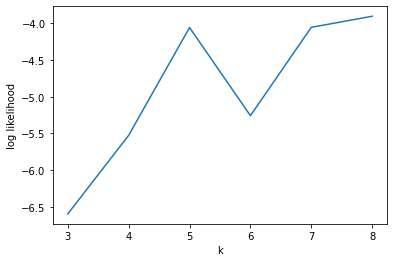

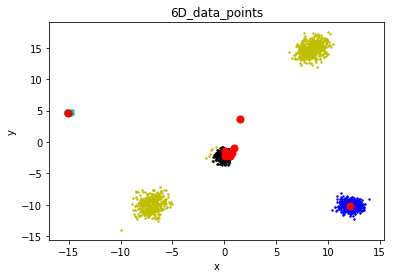

In [504]:
if __name__ == "__main__":
    main()